In [1]:
import numpy as np
import gensim
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

In [2]:
#사전 훈련된 GloVe 임베딩 다운로드
urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [3]:
glove_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8") # 100차원의 GloVe 벡터를 사용

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    glove_dict[word] = word_vector_arr
f.close()

In [5]:
glove_dict['cat']

array([ 0.23088  ,  0.28283  ,  0.6318   , -0.59411  , -0.58599  ,
        0.63255  ,  0.24402  , -0.14108  ,  0.060815 , -0.7898   ,
       -0.29102  ,  0.14287  ,  0.72274  ,  0.20428  ,  0.1407   ,
        0.98757  ,  0.52533  ,  0.097456 ,  0.8822   ,  0.51221  ,
        0.40204  ,  0.21169  , -0.013109 , -0.71616  ,  0.55387  ,
        1.1452   , -0.88044  , -0.50216  , -0.22814  ,  0.023885 ,
        0.1072   ,  0.083739 ,  0.55015  ,  0.58479  ,  0.75816  ,
        0.45706  , -0.28001  ,  0.25225  ,  0.68965  , -0.60972  ,
        0.19578  ,  0.044209 , -0.31136  , -0.68826  , -0.22721  ,
        0.46185  , -0.77162  ,  0.10208  ,  0.55636  ,  0.067417 ,
       -0.57207  ,  0.23735  ,  0.4717   ,  0.82765  , -0.29263  ,
       -1.3422   , -0.099277 ,  0.28139  ,  0.41604  ,  0.10583  ,
        0.62203  ,  0.89496  , -0.23446  ,  0.51349  ,  0.99379  ,
        1.1846   , -0.16364  ,  0.20653  ,  0.73854  ,  0.24059  ,
       -0.96473  ,  0.13481  , -0.0072484,  0.33016  , -0.1236

In [6]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [7]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
  return sum([glove_dict.get(word, zero_vector) 
                  for word in sentence])/len(sentence)

In [8]:
eng_sent = ['I', 'am', 'a', 'student']
sentence_vector = calculate_sentence_vector(eng_sent)
print(len(sentence_vector))

100


In [9]:
kor_sent = ['전', '좋은', '학생', '입니다']
sentence_vector = calculate_sentence_vector(kor_sent)
print(sentence_vector)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [13]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from urllib.request import urlretrieve
import zipfile
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
urlretrieve("https://raw.githubusercontent.com/prateekjoshi565/textrank_text_summarization/master/tennis_articles_v4.csv", filename="tennis_articles_v4.csv")
data = pd.read_csv("tennis_articles_v4.csv")
data.head()

,article_id,article_text,source
0,1,Maria Sharapova has basically no friends as te...,https://www.tennisworldusa.org/tennis/news/Mar...
1,2,"BASEL, Switzerland (AP), Roger Federer advance...",http://www.tennis.com/pro-game/2018/10/copil-s...
2,3,Roger Federer has revealed that organisers of ...,https://scroll.in/field/899938/tennis-roger-fe...
3,4,Kei Nishikori will try to end his long losing ...,http://www.tennis.com/pro-game/2018/10/nishiko...
4,5,"Federer, 37, first broke through on tour over ...",https://www.express.co.uk/sport/tennis/1036101...


In [19]:
data = data[['article_text']]
data['sentences'] = data['article_text'].apply(sent_tokenize)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,article_text,sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...


In [20]:
# 토큰화 함수
def tokenization(sentences):
    return [word_tokenize(sentence) for sentence in sentences]

# 전처리 함수
def preprocess_sentence(sentence):
  # 영어를 제외한 숫자, 특수 문자 등은 전부 제거. 모든 알파벳은 소문자화
  sentence = [re.sub(r'[^a-zA-z\s]', '', word).lower() for word in sentence]
  # 불용어가 아니면서 단어가 실제로 존재해야 한다.
  return [word for word in sentence if word not in stop_words and word]

# 위 전처리 함수를 모든 문장에 대해서 수행. 이 함수를 호출하면 모든 행에 대해서 수행.
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

In [21]:
data['tokenized_sentences'] = data['sentences'].apply(tokenization)
data['tokenized_sentences'] = data['tokenized_sentences'].apply(preprocess_sentences)
data

,article_text,sentences,tokenized_sentences
0,Maria Sharapova has basically no friends as te...,[Maria Sharapova has basically no friends as t...,"[[maria, sharapova, basically, friends, tennis..."
1,"BASEL, Switzerland (AP), Roger Federer advance...","[BASEL, Switzerland (AP), Roger Federer advanc...","[[basel, switzerland, ap, roger, federer, adva..."
2,Roger Federer has revealed that organisers of ...,[Roger Federer has revealed that organisers of...,"[[roger, federer, revealed, organisers, relaun..."
3,Kei Nishikori will try to end his long losing ...,[Kei Nishikori will try to end his long losing...,"[[kei, nishikori, try, end, long, losing, stre..."
4,"Federer, 37, first broke through on tour over ...","[Federer, 37, first broke through on tour over...","[[federer, first, broke, tour, two, decades, a..."
5,Nadal has not played tennis since he was force...,[Nadal has not played tennis since he was forc...,"[[nadal, played, tennis, since, forced, retire..."
6,"Tennis giveth, and tennis taketh away. The end...","[Tennis giveth, and tennis taketh away., The e...","[[tennis, giveth, tennis, taketh, away], [end,..."
7,Federer won the Swiss Indoors last week by bea...,[Federer won the Swiss Indoors last week by be...,"[[federer, swiss, indoors, last, week, beating..."


In [22]:
embedding_dim = 100
zero_vector = np.zeros(embedding_dim)

In [23]:
# 단어 벡터의 평균으로부터 문장 벡터를 얻는다.
def calculate_sentence_vector(sentence):
  if len(sentence) != 0:
    return sum([glove_dict.get(word, zero_vector) 
                  for word in sentence])/len(sentence)
  else:
    return zero_vector

In [24]:
# 각 문장에 대해서 문장 벡터를 반환
def sentences_to_vectors(sentences):
    return [calculate_sentence_vector(sentence) 
              for sentence in sentences]

In [25]:
data['SentenceEmbedding'] = data['tokenized_sentences'].apply(sentences_to_vectors)
data[['SentenceEmbedding']]

,SentenceEmbedding
0,"[[0.051488996, 0.1105585, 0.6950863, 0.1891917..."
1,"[[0.10566062456928194, -0.10534465219825506, 0..."
2,"[[-0.022272188, -0.0474477, 0.14933074, -0.086..."
3,"[[0.045201838, -0.064647146, 0.5035717, -0.160..."
4,"[[0.21536233, 0.180915, 0.25600883, 0.06924241..."
5,"[[0.04484453, -0.0074302587, 0.33349112, -0.07..."
6,"[[-0.115338005, -0.0062844106, 0.595185, -0.16..."
7,"[[0.0740439, 0.059211146, 0.49143884, 0.216771..."


In [26]:
def similarity_matrix(sentence_embedding):
  sim_mat = np.zeros([len(sentence_embedding), len(sentence_embedding)])
  for i in range(len(sentence_embedding)):
      for j in range(len(sentence_embedding)):
        sim_mat[i][j] = cosine_similarity(sentence_embedding[i].reshape(1, embedding_dim),
                                          sentence_embedding[j].reshape(1, embedding_dim))[0,0]
  return sim_mat

In [27]:
data['SimMatrix'] = data['SentenceEmbedding'].apply(similarity_matrix)
data['SimMatrix']

0    [[1.0, 0.6477208137512207, 0.5915699601173401,...
1    [[1.0000000000000002, 0.8745531210608369, 0.80...
2    [[0.9999998807907104, 0.913085401058197, 0.899...
3    [[0.9999999403953552, 0.7769179305294039, 0.84...
4    [[0.9999999403953552, 0.8306209732530097, 0.90...
5    [[1.0, 0.8843014240264893, 0.8540289072721128,...
6    [[1.0, 0.473054975271225, 0.45002683997154236,...
7    [[1.0000001192092896, 0.7634095600081803, 0.78...
Name: SimMatrix, dtype: object

In [28]:
print('두번째 샘플의 문장 개수 :',len(data['tokenized_sentences'][1]))
print('두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :',np.shape(data['SentenceEmbedding'][1]))
print('두번째 샘플의 유사도 행렬의 크기(shape) :',data['SimMatrix'][1].shape)

두번째 샘플의 문장 개수 : 12
두번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (12, 100)
두번째 샘플의 유사도 행렬의 크기(shape) : (12, 12)


In [29]:
def draw_graphs(sim_matrix):
  nx_graph = nx.from_numpy_array(sim_matrix)
  plt.figure(figsize=(10, 10))
  pos = nx.spring_layout(nx_graph)
  nx.draw(nx_graph, with_labels=True, font_weight='bold')
  nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
  plt.show()

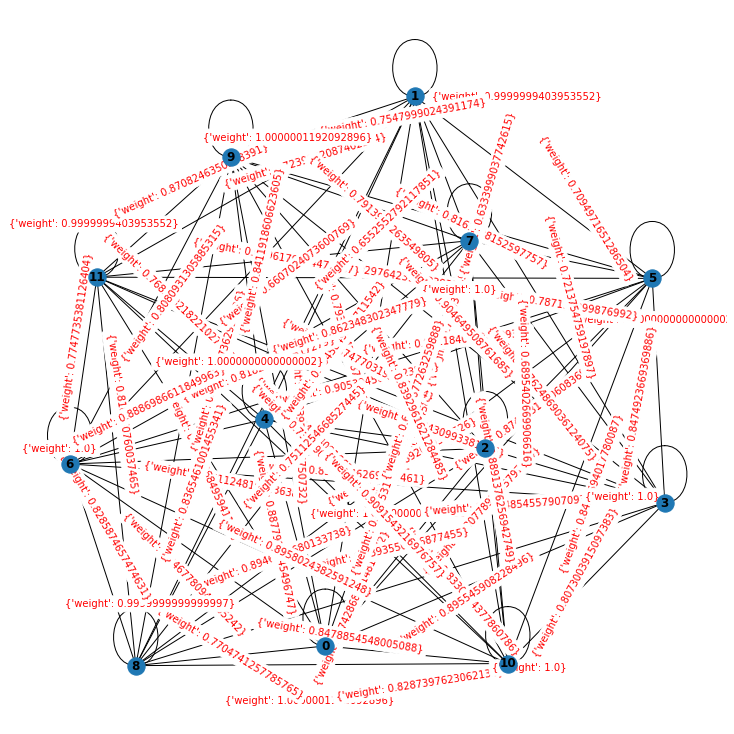

In [30]:
draw_graphs(data['SimMatrix'][1])

In [31]:
def calculate_score(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank(nx_graph)
    return scores

In [32]:
data['score'] = data['SimMatrix'].apply(calculate_score)
data[['SimMatrix', 'score']]

,SimMatrix,score
0,"[[1.0, 0.6477208137512207, 0.5915699601173401,...","{0: 0.054921591857231694, 1: 0.062865197127825..."
1,"[[1.0000000000000002, 0.8745531210608369, 0.80...","{0: 0.0831509438964348, 1: 0.08498611318825285..."
2,"[[0.9999998807907104, 0.913085401058197, 0.899...","{0: 0.06148440450562715, 1: 0.0622486436175160..."
3,"[[0.9999999403953552, 0.7769179305294039, 0.84...","{0: 0.08164728322073438, 1: 0.0727647939629649..."
4,"[[0.9999999403953552, 0.8306209732530097, 0.90...","{0: 0.05568689673271279, 1: 0.0509923171787943..."
5,"[[1.0, 0.8843014240264893, 0.8540289072721128,...","{0: 0.08288694384176991, 1: 0.0840376031405664..."
6,"[[1.0, 0.473054975271225, 0.45002683997154236,...","{0: 0.07336251821036095, 1: 0.1050889009405666..."
7,"[[1.0000001192092896, 0.7634095600081803, 0.78...","{0: 0.043210395251217094, 1: 0.047333397704124..."


In [33]:
data['score'][1]

{0: 0.0831509438964348,
 1: 0.08498611318825285,
 2: 0.0855501969882867,
 3: 0.08383717254942684,
 4: 0.0813793988323122,
 5: 0.0843928498199495,
 6: 0.08507725733330257,
 7: 0.08092839239693102,
 8: 0.07454046010944942,
 9: 0.08535837210459046,
 10: 0.08498242787885528,
 11: 0.08581641490220814}

In [34]:
def ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s) 
                         for i,s in enumerate(sentences)), 
                                reverse=True)
    top_n_sentences = [sentence 
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

In [35]:
data['summary'] = data.apply(lambda x: 
                            ranked_sentences(x.sentences, 
                            x.score), axis=1)

In [36]:
for i in range(0, len(data)):
  print(i+1,'번 문서')
  print('원문 :',data.loc[i].article_text)
  print('')
  print('요약 :',data.loc[i].summary)
  print('')

1 번 문서
원문 : Maria Sharapova has basically no friends as tennis players on the WTA Tour. The Russian player has no problems in openly speaking about it and in a recent interview she said: 'I don't really hide any feelings too much. I think everyone knows this is my job here. When I'm on the courts or when I'm on the court playing, I'm a competitor and I want to beat every single person whether they're in the locker room or across the net.So I'm not the one to strike up a conversation about the weather and know that in the next few minutes I have to go and try to win a tennis match. I'm a pretty competitive girl. I say my hellos, but I'm not sending any players flowers as well. Uhm, I'm not really friendly or close to many players. I have not a lot of friends away from the courts.' When she said she is not really close to a lot of players, is that something strategic that she is doing? Is it different on the men's tour than the women's tour? 'No, not at all. I think just because you're i